- Manually gen rules for amazon (sample some rows if taking too long) – just test with snorkel, no repair needed
- Create a utility to test the candidate rule accuracies 
- Test them by adding / accumulating them to see if we see improvement in global accuracy etc. Based on the results , we can see what rules from r_{gold} can the current algorithm produce. Then use r_{gold} as starting point and test via subset of rules.
- Compare r_{gold} with r_{witan}


Step 1: gen rules based on some samples:
Required components:
- A sampler to get sampled sentences from the dataset (sentence, ground truth label)
- A template for user to write
- Translate to TreeRule objects
- Test utility to gen accuracy on the dataset for this candidate LF

Step 2: given a list of rules (TreeRules), actually run with Snorkel to see the results
Required components:
- A way to specify the list of rules (could be pickle file and display user-friendly formats in order for user to specify?)
- Save the ruleset with a filename

In [151]:
# the original Amazon global accuracy with witan rules(15) is 0.64

In [152]:
from rbbm_src.labelling_func_src.src.lfs_tree import keyword_labelling_func_builder
from rbbm_src.labelling_func_src.src.TreeRules import SPAM, HAM, ABSTAIN
from rbbm_src.labelling_func_src.src.LFRepair import run_snorkel
from rbbm_src.labelling_func_src.src.classes import clean_text
import re
import pandas as pd
import psycopg2
import pandas as pd
from snorkel.labeling import (
	LabelingFunction, 
	labeling_function, 
	PandasLFApplier, 
	LFAnalysis,
	filter_unlabeled_dataframe
	)
from snorkel.labeling.model import MajorityLabelVoter, LabelModel
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import matplotlib.patches as mpatches

In [153]:
from rbbm_src.labelling_func_src.src.example_tree_rules import gen_amazon_funcs

In [154]:
def calculate_coverage(df, lf_column):
    total_instances = len(df)
    labeled_instances = df[lf_column] != -1
    coverage = labeled_instances.sum() / total_instances
    return coverage

def calculate_accuracy(df, lf_column, ground_truth_column):
    labeled_instances = df[df[lf_column] != -1]
    correct_labels = (labeled_instances[lf_column] == labeled_instances[ground_truth_column]).sum()
    total_labeled = len(labeled_instances)
    if total_labeled == 0:
        return 0.0  # Avoid division by zero if no instances are labeled
    accuracy = correct_labels / total_labeled
    return accuracy

In [155]:
# mapping_dict = {'negative':SPAM, 'positive':HAM}

In [156]:
# kwords_and_label_re = re.compile('\((.*)\)->(\w+)')

In [157]:
# kwords_and_label_re.search('(common,subscribe)->negative').groups()

In [158]:
# load amazon dataset

In [159]:
conn = psycopg2.connect(dbname='label', user='postgres')

In [160]:
sentences_df=pd.read_sql(f'SELECT * FROM amazon01', conn)
sentences_df = sentences_df.rename(columns={"class": "expected_label", "content": "old_text"})
sentences_df['text'] = sentences_df['old_text'].apply(lambda s: clean_text(s))
sentences_df = sentences_df[~sentences_df['text'].isna()]

/tmp/ipykernel_1448/3647735799.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  sentences_df=pd.read_sql(f'SELECT * FROM amazon01', conn)


In [161]:
from collections import defaultdict

In [162]:
individual_func_stats = defaultdict(dict)

In [163]:
amazon_treerules = gen_amazon_funcs()

In [164]:
amazon_funcs = [f.gen_label_rule() for f in amazon_treerules]

In [165]:
for f in amazon_funcs:
    print(f)
    sentences_df['lf_labeled'] = sentences_df.apply(f, axis=1)
    cov=calculate_coverage(df=sentences_df, lf_column='lf_labeled')
    acc=calculate_accuracy(df=sentences_df, lf_column='lf_labeled', ground_truth_column='expected_label')
    individual_func_stats[f]={'cov':cov, 'acc':acc}
    print(f"cov:{round(cov,2)}, acc:{round(acc,2)}")
    print('\n')

PredicateNode(id=1, pred=keyword_predicate-word-(star,stars))
    LabelNode(id=2, label=-1)
    LabelNode(id=3, label=0)
cov:0.28, acc:0.55


PredicateNode(id=1, pred=keyword_predicate-word-(product,fit,quality,size,cheap,wear))
    LabelNode(id=2, label=-1)
    LabelNode(id=3, label=1)
cov:0.29, acc:0.54


PredicateNode(id=1, pred=keyword_predicate-word-(great))
    LabelNode(id=2, label=-1)
    LabelNode(id=3, label=0)
cov:0.21, acc:0.82


PredicateNode(id=1, pred=keyword_predicate-word-(great))
    LabelNode(id=2, label=-1)
    PredicateNode(id=3, pred=keyword_predicate-word-(stars,works))
        LabelNode(id=4, label=-1)
        LabelNode(id=5, label=0)
cov:0.06, acc:0.91


PredicateNode(id=1, pred=keyword_predicate-word-(waste))
    LabelNode(id=2, label=-1)
    LabelNode(id=3, label=1)
cov:0.05, acc:0.97


PredicateNode(id=1, pred=keyword_predicate-word-(shoes,item,price,comfortable,plastic))
    LabelNode(id=2, label=-1)
    LabelNode(id=3, label=0)
cov:0.14, acc:0.54


Predica

In [166]:
applier = PandasLFApplier(lfs=amazon_funcs)
initial_vectors = applier.apply(df=sentences_df, progress_bar=False)
model = LabelModel(cardinality=2, verbose=True, device='cpu')
model.fit(L_train=initial_vectors, n_epochs=500, log_freq=100, seed=123)

probs_test= model.predict_proba(L=initial_vectors)


INFO 2024-08-15 13:21:33,477 [label_model.py:fit:905] Computing O...
INFO 2024-08-15 13:21:33,484 [label_model.py:fit:911] Estimating \mu...
 14%|███▌                     | 72/500 [00:00<00:01, 218.98epoch/s]INFO 2024-08-15 13:21:33,842 [logger.py:log:79] [100 epochs]: TRAIN:[loss=0.033]
INFO 2024-08-15 13:21:33,918 [logger.py:log:79] [200 epochs]: TRAIN:[loss=0.033]
100%|████████████████████████| 500/500 [00:00<00:00, 754.81epoch/s]
INFO 2024-08-15 13:21:34,150 [label_model.py:fit:977] Finished Training


In [167]:
df_sentences_filtered, probs_test_filtered, filtered_vectors, df_no_signal  = filter_unlabeled_dataframe(
        X=sentences_df, y=probs_test, L=initial_vectors
)	

df_sentences_filtered = df_sentences_filtered.reset_index(drop=True)
prob_diffs = [abs(t[0]-t[1]) for t in probs_test_filtered]
prob_diffs_tuples = [(t[0],t[1]) for t in probs_test_filtered]
df_sentences_filtered['model_pred_diff'] = pd.Series(prob_diffs)
df_sentences_filtered['model_pred_prob_tuple'] = pd.Series(prob_diffs_tuples)
df_sentences_filtered['model_pred'] = pd.Series(model.predict(L=filtered_vectors))

wrong_preds = df_sentences_filtered[(df_sentences_filtered['expected_label']!=df_sentences_filtered['model_pred'])]
# df_sentences_filtered.to_csv('predictions_shakira.csv', index=False)
# logger.critical(wrong_preds)
accuracy=(len(df_sentences_filtered)-len(wrong_preds))/len(df_sentences_filtered)

print(f"""
    out of {len(sentences_df)} sentences, {len(df_sentences_filtered)} actually got at least one signal to \n
    make prediction. Out of all the valid predictions, we have {len(wrong_preds)} wrong predictions, \n
    accuracy = {(len(df_sentences_filtered)-len(wrong_preds))/len(df_sentences_filtered)} 
    """)


    out of 19946 sentences, 18915 actually got at least one signal to 

    make prediction. Out of all the valid predictions, we have 6918 wrong predictions, 

    accuracy = 0.6342585249801744 
    


In [185]:
(18915-6918)/19946

0.6014739797453124

In [168]:
# Analyze the labels
analysis = LFAnalysis(L=initial_vectors, lfs=amazon_funcs)
analysis.lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
"PredicateNode(id=1, pred=keyword_predicate-word-(star,stars))\n LabelNode(id=2, label=-1)\n LabelNode(id=3, label=0)",0,[0],0.282463,0.225709,0.175173
"PredicateNode(id=1, pred=keyword_predicate-word-(product,fit,quality,size,cheap,wear))\n LabelNode(id=2, label=-1)\n LabelNode(id=3, label=1)",1,[1],0.290635,0.281911,0.207410
"PredicateNode(id=1, pred=keyword_predicate-word-(great))\n LabelNode(id=2, label=-1)\n LabelNode(id=3, label=0)",2,[0],0.206457,0.191768,0.162288
"PredicateNode(id=1, pred=keyword_predicate-word-(great))\n LabelNode(id=2, label=-1)\n PredicateNode(id=3, pred=keyword_predicate-word-(stars,works))\n LabelNode(id=4, label=-1)\n LabelNode(id=5, label=0)",3,[0],0.055149,0.055149,0.040058
"PredicateNode(id=1, pred=keyword_predicate-word-(waste))\n LabelNode(id=2, label=-1)\n LabelNode(id=3, label=1)",4,[1],0.049283,0.047729,0.020906
"PredicateNode(id=1, pred=keyword_predicate-word-(shoes,item,price,comfortable,plastic))\n LabelNode(id=2, label=-1)\n LabelNode(id=3, label=0)",5,[0],0.138775,0.135566,0.123233
"PredicateNode(id=1, pred=keyword_predicate-word-(junk,bought,like,dont,just,use,buy,work,small,didnt,did,disappointed))\n LabelNode(id=2, label=-1)\n LabelNode(id=3, label=1)",6,[1],0.626090,0.544320,0.395969
"PredicateNode(id=0, pred=keyword_predicate-word-(junk,bought,like,dont,just,use,buy,work,small,didnt,did,disappointed))\n LabelNode(id=2, label=-1)\n PredicateNode(id=3, pred=keyword_predicate-word-(shoes,metal,fabric,replace,battery,warranty,plug))\n LabelNode(id=4, label=-1)\n LabelNode(id=5, label=1)",7,[1],0.069287,0.069287,0.051389
"PredicateNode(id=1, pred=keyword_predicate-word-(love,perfect,loved,nice,excellent,works,loves,awesome,easy))\n LabelNode(id=2, label=-1)\n LabelNode(id=3, label=0)",8,[0],0.349042,0.323524,0.274892
"PredicateNode(id=1, pred=keyword_predicate-word-(love,perfect,loved,nice,excellent,works,loves,awesome,easy))\n LabelNode(id=2, label=-1)\n PredicateNode(id=3, pred=keyword_predicate-word-(stars,soft))\n LabelNode(id=4, label=-1)\n LabelNode(id=5, label=0)",9,[0],0.071794,0.071794,0.042214


In [169]:
lf_vectors = filtered_vectors
ground_truth = df_sentences_filtered['expected_label']
snorkel_predictions = df_sentences_filtered['model_pred']
snorkel_probs = df_sentences_filtered['model_pred_diff']

In [170]:
lf_vectors.shape

(18915, 15)

In [171]:
snorkel_predictions.shape

(18915,)

In [172]:
valid_label_counts = np.sum(lf_vectors != ABSTAIN, axis=1)


In [173]:
valid_label_counts.shape

(18915,)

In [174]:
# Define the abstain label
abstain_label = -1

# Calculate the majority vote for each instance
def majority_vote(labels):
    valid_labels = [label for label in labels if label != abstain_label]
    if valid_labels:
        return Counter(valid_labels).most_common(1)[0][0]
    else:
        return abstain_label

majority_votes = np.array([majority_vote(row) for row in lf_vectors])

# Count the number of valid (non-abstain) labels for each instance



DEBUG 2024-08-15 13:21:34,809 [ticker.py:tick_values:2375] vmin 0.6588020924625325 vmax 6399.493942469184
DEBUG 2024-08-15 13:21:34,810 [ticker.py:tick_values:2433] ticklocs array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05])
DEBUG 2024-08-15 13:21:34,819 [ticker.py:tick_values:2375] vmin 0.6588020924625325 vmax 6399.493942469184
DEBUG 2024-08-15 13:21:34,819 [ticker.py:tick_values:2433] ticklocs array([2.e-02, 3.e-02, 4.e-02, 5.e-02, 6.e-02, 7.e-02, 8.e-02, 9.e-02,
       2.e-01, 3.e-01, 4.e-01, 5.e-01, 6.e-01, 7.e-01, 8.e-01, 9.e-01,
       2.e+00, 3.e+00, 4.e+00, 5.e+00, 6.e+00, 7.e+00, 8.e+00, 9.e+00,
       2.e+01, 3.e+01, 4.e+01, 5.e+01, 6.e+01, 7.e+01, 8.e+01, 9.e+01,
       2.e+02, 3.e+02, 4.e+02, 5.e+02, 6.e+02, 7.e+02, 8.e+02, 9.e+02,
       2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03, 9.e+03,
       2.e+04, 3.e+04, 4.e+04, 5.e+04, 6.e+04, 7.e+04, 8.e+04, 9.e+04,
       2.e+05, 3.e+05, 4.e+05, 5.e+05, 6.e+05, 7.e+05, 8.e+05, 9.e+05])
DEBUG 2024-

DEBUG 2024-08-15 13:21:35,234 [ticker.py:tick_values:2433] ticklocs array([2.e-02, 3.e-02, 4.e-02, 5.e-02, 6.e-02, 7.e-02, 8.e-02, 9.e-02,
       2.e-01, 3.e-01, 4.e-01, 5.e-01, 6.e-01, 7.e-01, 8.e-01, 9.e-01,
       2.e+00, 3.e+00, 4.e+00, 5.e+00, 6.e+00, 7.e+00, 8.e+00, 9.e+00,
       2.e+01, 3.e+01, 4.e+01, 5.e+01, 6.e+01, 7.e+01, 8.e+01, 9.e+01,
       2.e+02, 3.e+02, 4.e+02, 5.e+02, 6.e+02, 7.e+02, 8.e+02, 9.e+02,
       2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03, 9.e+03,
       2.e+04, 3.e+04, 4.e+04, 5.e+04, 6.e+04, 7.e+04, 8.e+04, 9.e+04,
       2.e+05, 3.e+05, 4.e+05, 5.e+05, 6.e+05, 7.e+05, 8.e+05, 9.e+05])
DEBUG 2024-08-15 13:21:35,236 [ticker.py:tick_values:2375] vmin 0.6588020924625325 vmax 6399.493942469184
DEBUG 2024-08-15 13:21:35,237 [ticker.py:tick_values:2433] ticklocs array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05])
DEBUG 2024-08-15 13:21:35,255 [ticker.py:tick_values:2375] vmin 0.6588020924625325 vmax 6399.493942469184
DEBUG 2024-

DEBUG 2024-08-15 13:21:35,483 [ticker.py:tick_values:2375] vmin 0.6588020924625325 vmax 6399.493942469184
DEBUG 2024-08-15 13:21:35,484 [ticker.py:tick_values:2433] ticklocs array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05])
DEBUG 2024-08-15 13:21:35,485 [ticker.py:tick_values:2375] vmin 0.6588020924625325 vmax 6399.493942469184
DEBUG 2024-08-15 13:21:35,485 [ticker.py:tick_values:2433] ticklocs array([2.e-02, 3.e-02, 4.e-02, 5.e-02, 6.e-02, 7.e-02, 8.e-02, 9.e-02,
       2.e-01, 3.e-01, 4.e-01, 5.e-01, 6.e-01, 7.e-01, 8.e-01, 9.e-01,
       2.e+00, 3.e+00, 4.e+00, 5.e+00, 6.e+00, 7.e+00, 8.e+00, 9.e+00,
       2.e+01, 3.e+01, 4.e+01, 5.e+01, 6.e+01, 7.e+01, 8.e+01, 9.e+01,
       2.e+02, 3.e+02, 4.e+02, 5.e+02, 6.e+02, 7.e+02, 8.e+02, 9.e+02,
       2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03, 9.e+03,
       2.e+04, 3.e+04, 4.e+04, 5.e+04, 6.e+04, 7.e+04, 8.e+04, 9.e+04,
       2.e+05, 3.e+05, 4.e+05, 5.e+05, 6.e+05, 7.e+05, 8.e+05, 9.e+05])
DEBUG 2024-

DEBUG 2024-08-15 13:21:35,619 [ticker.py:tick_values:2375] vmin 0.6588020924625325 vmax 6399.493942469184
DEBUG 2024-08-15 13:21:35,620 [ticker.py:tick_values:2433] ticklocs array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05])
DEBUG 2024-08-15 13:21:35,660 [ticker.py:tick_values:2375] vmin 0.6588020924625325 vmax 6399.493942469184
DEBUG 2024-08-15 13:21:35,660 [ticker.py:tick_values:2433] ticklocs array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05])
DEBUG 2024-08-15 13:21:35,662 [ticker.py:tick_values:2375] vmin 0.6588020924625325 vmax 6399.493942469184
DEBUG 2024-08-15 13:21:35,662 [ticker.py:tick_values:2433] ticklocs array([2.e-02, 3.e-02, 4.e-02, 5.e-02, 6.e-02, 7.e-02, 8.e-02, 9.e-02,
       2.e-01, 3.e-01, 4.e-01, 5.e-01, 6.e-01, 7.e-01, 8.e-01, 9.e-01,
       2.e+00, 3.e+00, 4.e+00, 5.e+00, 6.e+00, 7.e+00, 8.e+00, 9.e+00,
       2.e+01, 3.e+01, 4.e+01, 5.e+01, 6.e+01, 7.e+01, 8.e+01, 9.e+01,
       2.e+02, 3.e+02, 4.e+02, 5.e+02, 6.e+02, 7.e

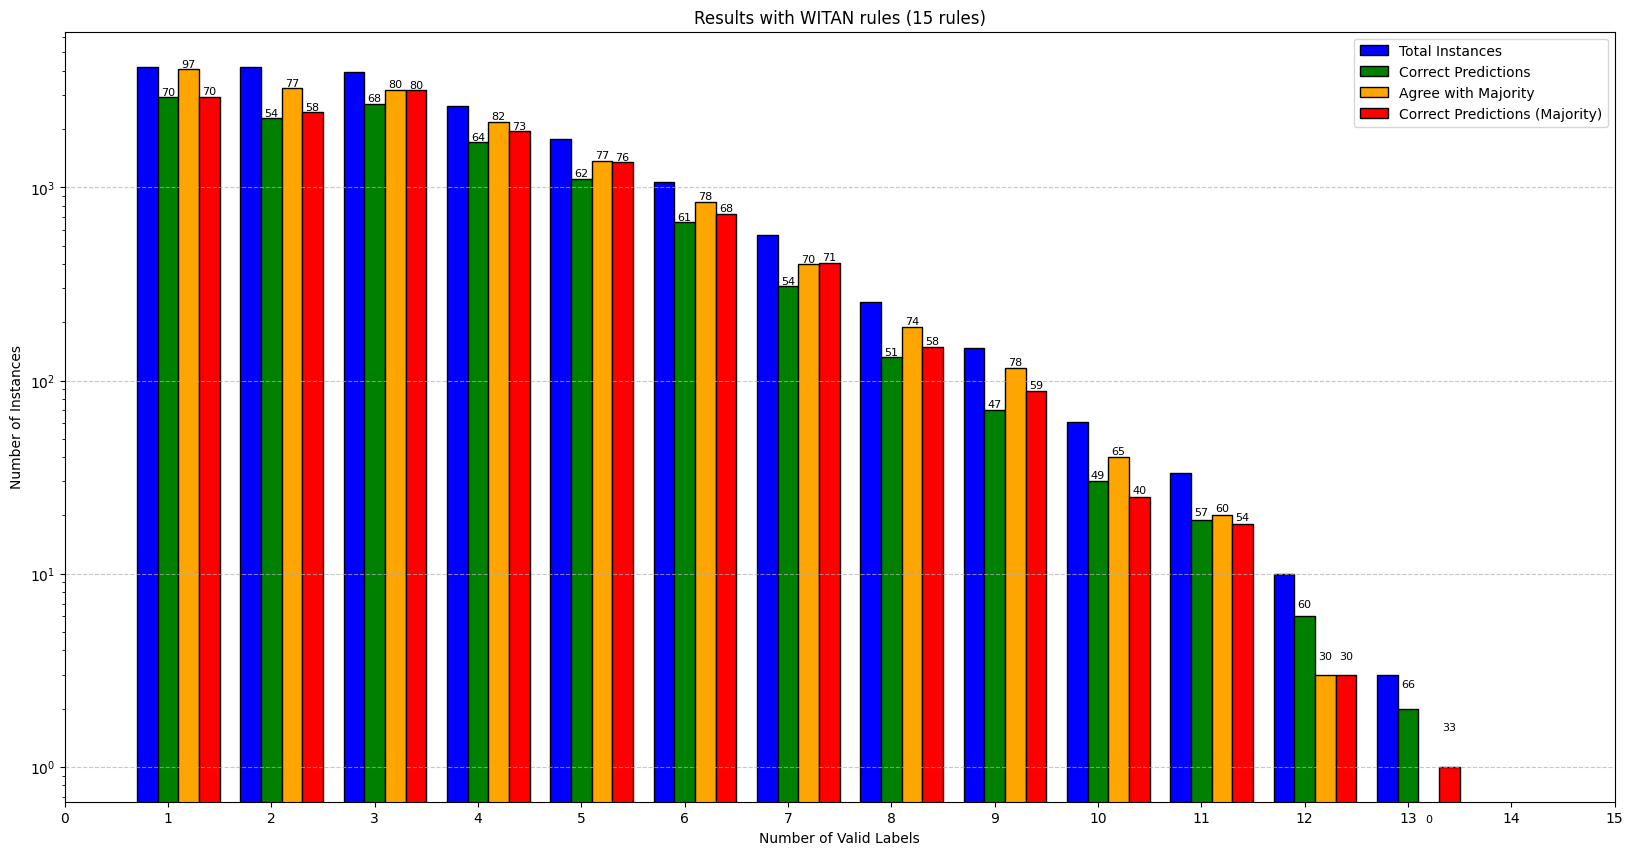

In [175]:
valid_label_counts = np.sum(lf_vectors != abstain_label, axis=1)

# Determine the number of correct Snorkel predictions
correct_predictions = (snorkel_predictions == ground_truth)

# Determine the number of Snorkel predictions that agree with the majority vote
agree_with_majority = (snorkel_predictions == majority_votes)

# correct majority results
correct_majority_predictions = (majority_votes == ground_truth)

# Count the total instances, correct predictions, and agreements with majority vote for each number of valid labels
max_valid_labels = 27
total_counts = Counter(valid_label_counts)
correct_counts = Counter(valid_label_counts[correct_predictions])
agree_counts = Counter(valid_label_counts[agree_with_majority])
correct_majority_counts = Counter(valid_label_counts[correct_majority_predictions])


# Prepare data for plotting
x = np.arange(max_valid_labels + 1)
total_instances = np.array([total_counts[i] for i in x])
correct_instances = np.array([correct_counts[i] for i in x])
agree_instances = np.array([agree_counts[i] for i in x])
correct_majority_instances = np.array([correct_majority_counts[i] for i in x])


# Calculate the ratio for annotations
ratios_correct = np.divide(correct_instances, total_instances, out=np.zeros_like(correct_instances, dtype=float), where=total_instances != 0)
ratios_agree = np.divide(agree_instances, total_instances, out=np.zeros_like(correct_instances, dtype=float), where=total_instances != 0)
ratios_correct_majority = np.divide(correct_majority_instances, total_instances, out=np.zeros_like(correct_majority_instances, dtype=float), where=total_instances != 0)


plt.figure(figsize=(20, 10))
bar_width = 0.2  # Increase the bar width
total_bars = plt.bar(x - bar_width, total_instances, bar_width, label='Total Instances', color='blue', edgecolor='black')
correct_bars = plt.bar(x, correct_instances, bar_width, label='Correct Predictions', color='green', edgecolor='black')
agree_bars = plt.bar(x + bar_width, agree_instances, bar_width, label='Agree with Majority', color='orange', edgecolor='black')
correct_majority_bars = plt.bar(x + 2 * bar_width, correct_majority_instances, bar_width, label='Correct Predictions (Majority)', color='red', edgecolor='black')


plt.xlabel('Number of Valid Labels')
plt.ylabel('Number of Instances')
plt.title('Results with WITAN rules (15 rules)')
plt.xticks(x)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Limit the x-axis range
plt.xlim(0, 15)  # Adjust the range as needed
plt.yscale('log')
# Add annotations for the ratios
for i in range(len(x)):
    if total_instances[i] > 0:  # Only add text if there are instances
        plt.text(x[i], correct_instances[i] + 0.5, f'{int(ratios_correct[i]*100)}', ha='center', va='bottom', fontsize=8)
        plt.text(x[i] + bar_width, agree_instances[i] + 0.5, f'{int(ratios_agree[i]*100)}', ha='center', va='bottom', fontsize=8)
        plt.text(x[i] + 2 * bar_width, correct_majority_instances[i] + 0.5, f'{int(ratios_correct_majority[i]*100)}', ha='center', va='bottom', fontsize=8, color='black')
plt.savefig('distribution_of_labels_witan_rules_only.pdf', format='pdf')
plt.show()

In [183]:
def drill_down_dist(lf_vectors, chosen_valid_labels, snorkel_probs, snorkel_preds):
    # Filter the data for instances with the chosen number of valid labels
    # valid_label_counts = np.sum(initial_vectors != abstain_label, axis=1)
    filtered_indices = np.where(valid_label_counts == chosen_valid_labels)[0]
    # lf_vectors = initial_vectors[filtered_indices]
    lf_vectors_for_chosen_valid_labels = lf_vectors[filtered_indices]
        #  Calculate the number of spam, ham, and abstain labels
    spam_counts = np.sum(lf_vectors_for_chosen_valid_labels == SPAM, axis=1)
    ham_counts = np.sum(lf_vectors_for_chosen_valid_labels == HAM, axis=1)
    abstain_counts = np.sum(lf_vectors_for_chosen_valid_labels == abstain_label, axis=1)

    # Calculate the breakdown for each number of spam labels (x-axis)
    x_vals = np.arange(chosen_valid_labels + 1)

    array = []
    for i in x_vals:
        mask = (spam_counts == i)

        e = [
            np.sum(mask),  # Number of Spam labels
    #         np.sum(ham_counts[mask]),  # Number of Ham labels
    #         np.sum(abstain_counts[mask])  # Number of Abstain labels
        ]

        array.append(e)

    spam_ham_abstain = np.array(array)


    # Calculate the number of correct predictions by Snorkel vs. Ground Truth
    correct_predictions = snorkel_predictions[filtered_indices] == ground_truth[filtered_indices]
    correct_counts = np.array([
        np.sum((spam_counts == i) & correct_predictions) for i in x_vals
    ])

    # Plotting the stacked bar plot for the breakdown
    plt.figure(figsize=(14, 8))

    # Stacked bar plot for spam, ham, and abstain
    plt.bar(x_vals, spam_ham_abstain[:, 0], label='#Spam labe', color='red', width=0.5)
    # plt.bar(x_vals, spam_ham_abstain[:, 1], bottom=spam_ham_abstain[:, 0], label='Ham', color='green')
    # plt.bar(x_vals, spam_ham_abstain[:, 2], bottom=spam_ham_abstain[:, 0] + spam_ham_abstain[:, 1], label='Abstain', color='grey')

    # Bar plot for correct predictions by Snorkel vs. Ground Truth
    plt.bar(x_vals + 0.4, correct_counts, width=0.4, label='Correct Predictions', color='blue')

    plt.xlabel('Number of Spam Labels', fontsize=14)
    plt.ylabel('Number of Instances', fontsize=14)
    plt.title(f'Breakdown for {chosen_valid_labels} Valid Labels', fontsize=16)
    plt.xticks(x_vals + 0.2, x_vals)  # Align x-ticks with the center of the grouped bars
    plt.legend(fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)


    plt.show()


    plt.figure(figsize=(14, 8))

    boxplot_data = [snorkel_probs[filtered_indices][spam_counts == i] for i in x_vals]
    # print([b.tolist() for b in boxplot_data])
    plt.boxplot(boxplot_data, positions=x_vals, patch_artist=True)
    plt.legend(fontsize=12)

    plt.show()


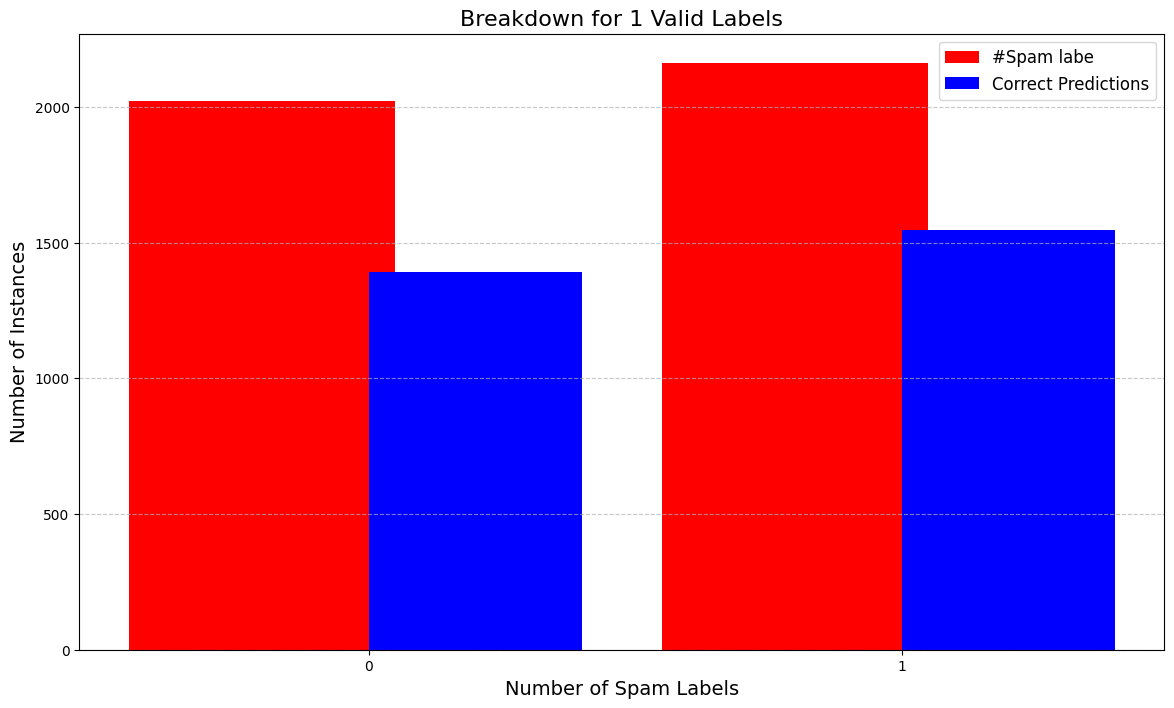

WARNING 2024-08-15 13:37:21,971 [legend.py:_parse_legend_args:1236] No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


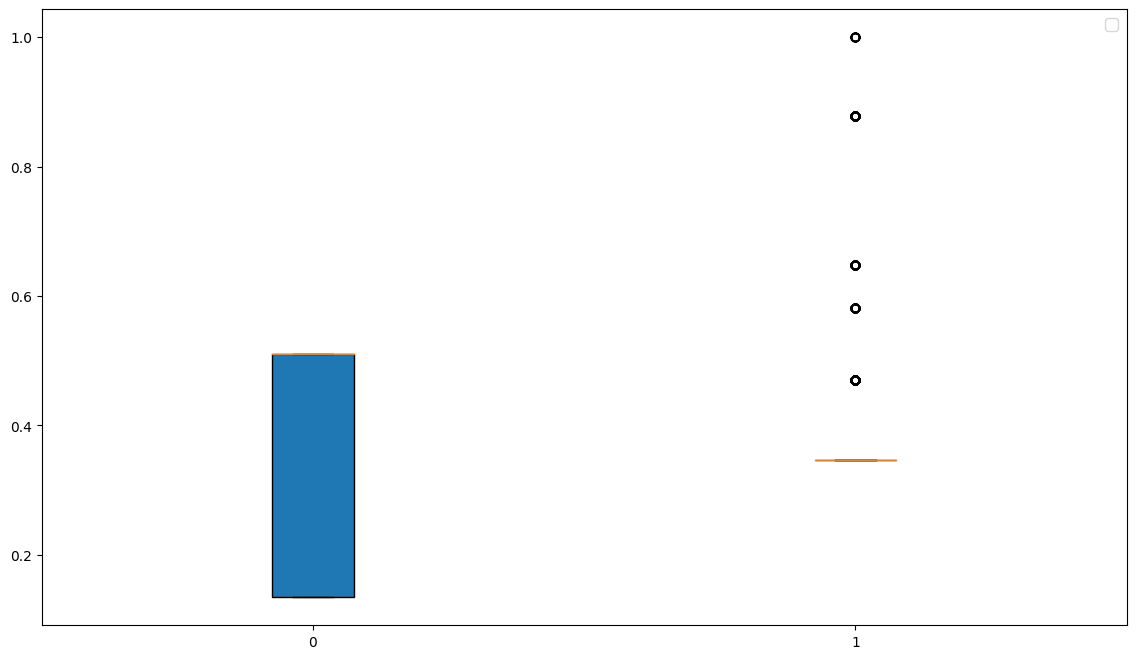

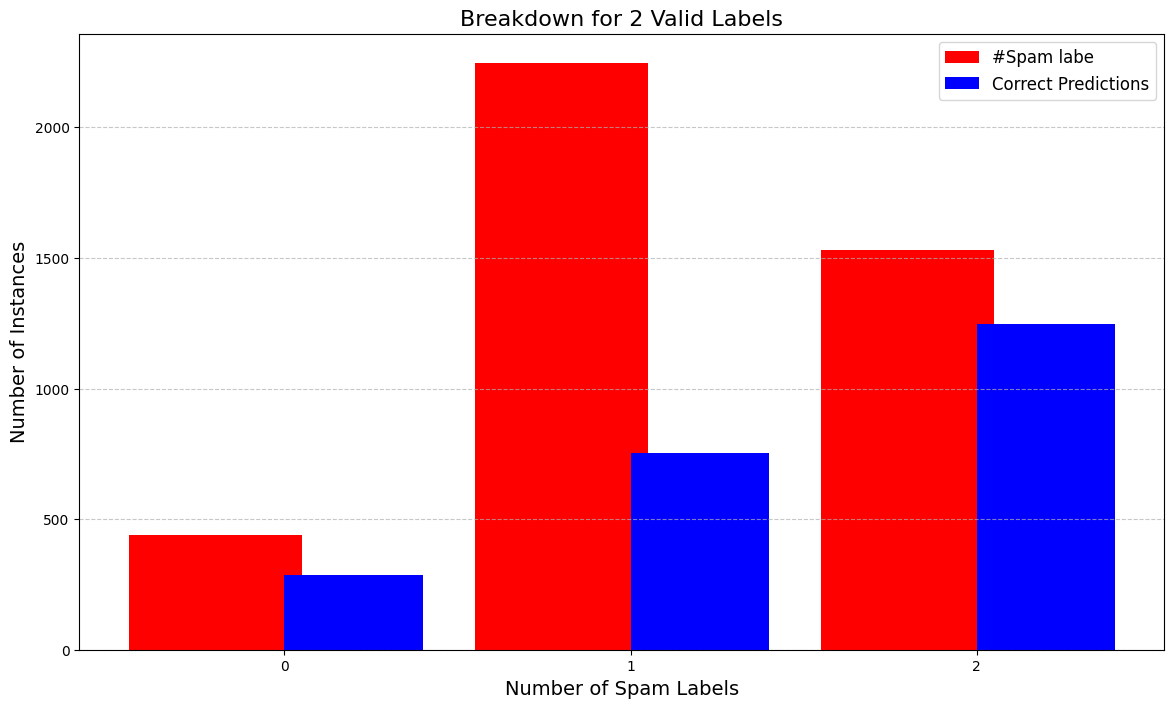

WARNING 2024-08-15 13:37:22,268 [legend.py:_parse_legend_args:1236] No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


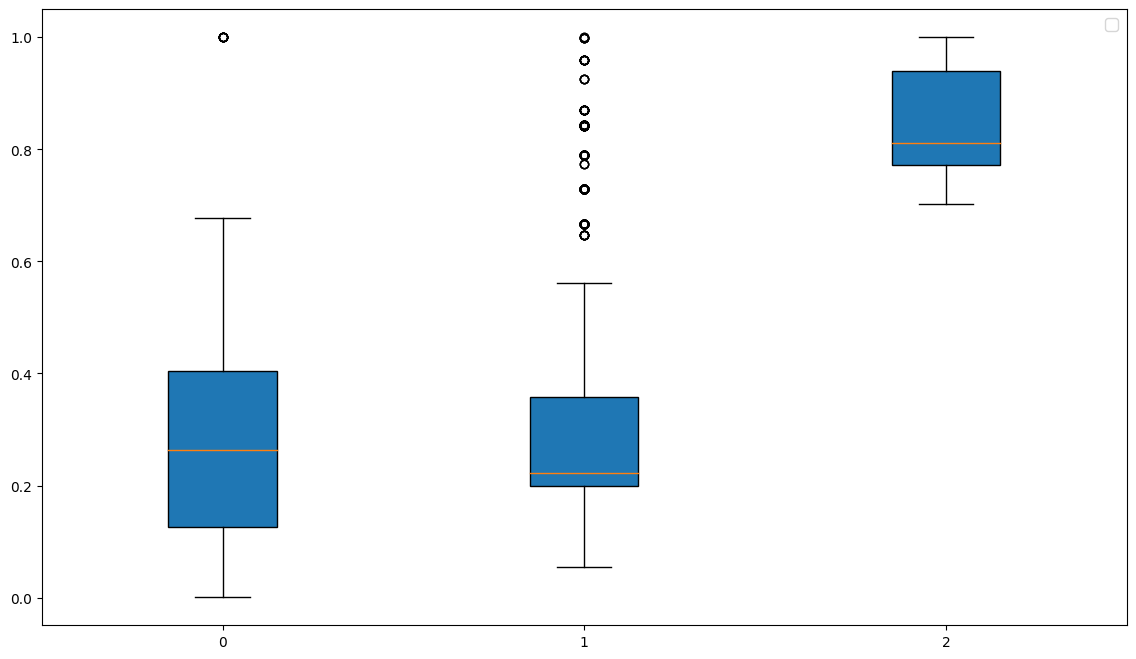

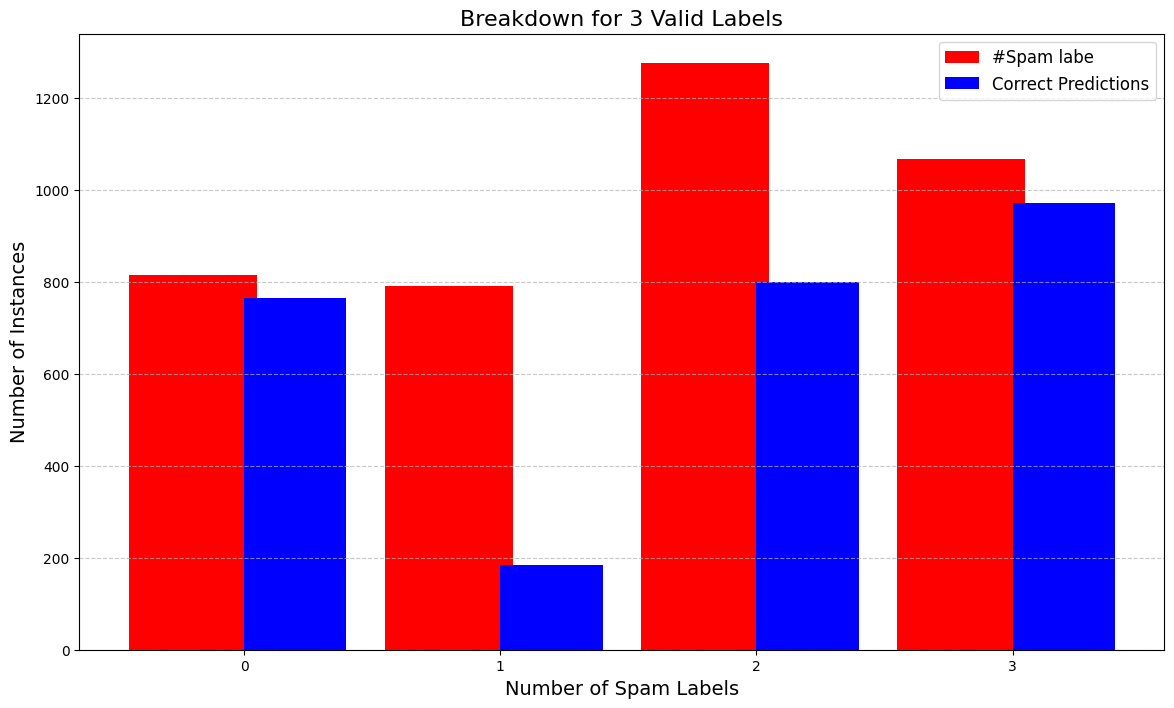

WARNING 2024-08-15 13:37:22,601 [legend.py:_parse_legend_args:1236] No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


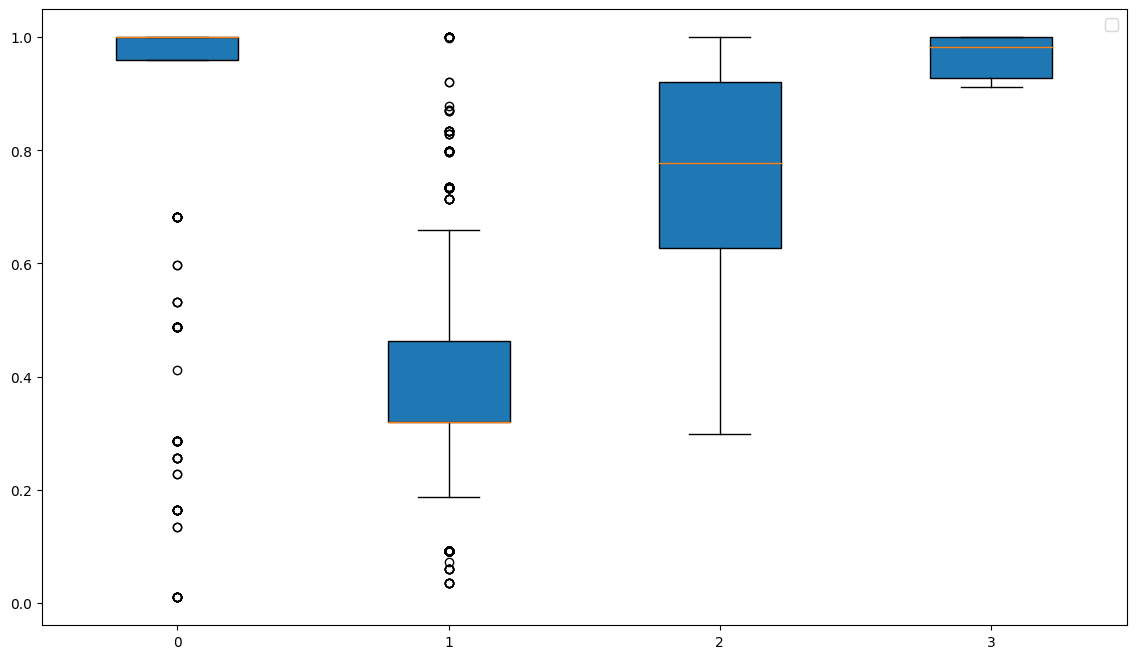

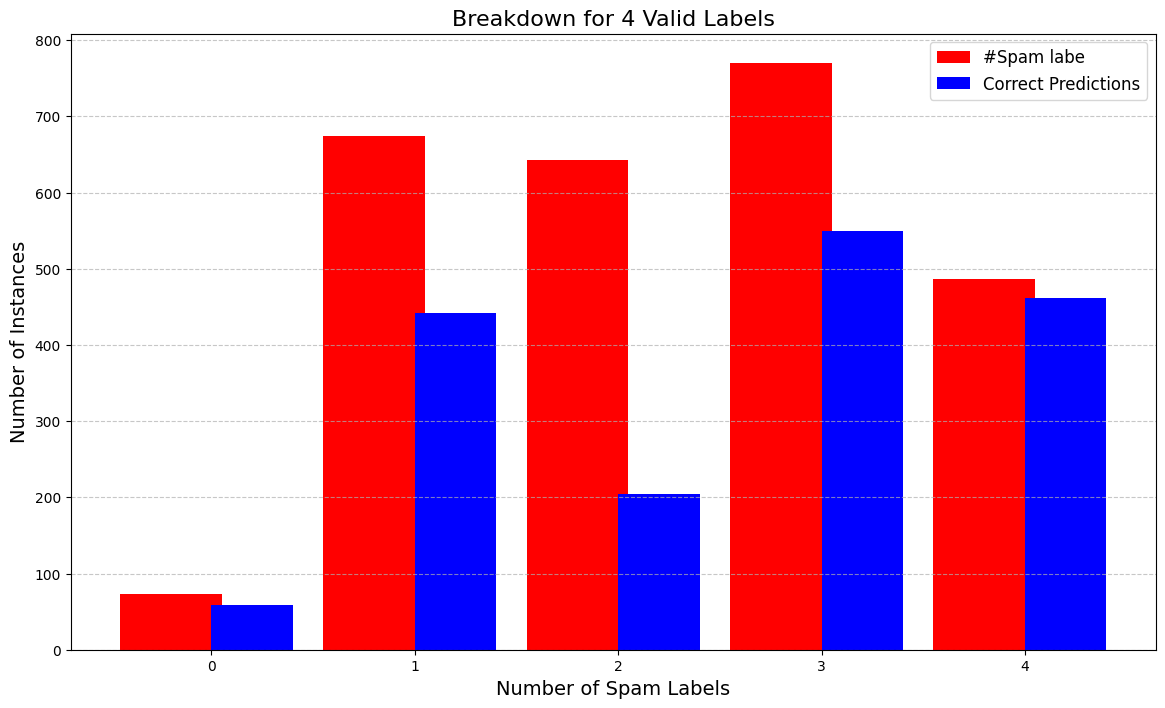

WARNING 2024-08-15 13:37:22,971 [legend.py:_parse_legend_args:1236] No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


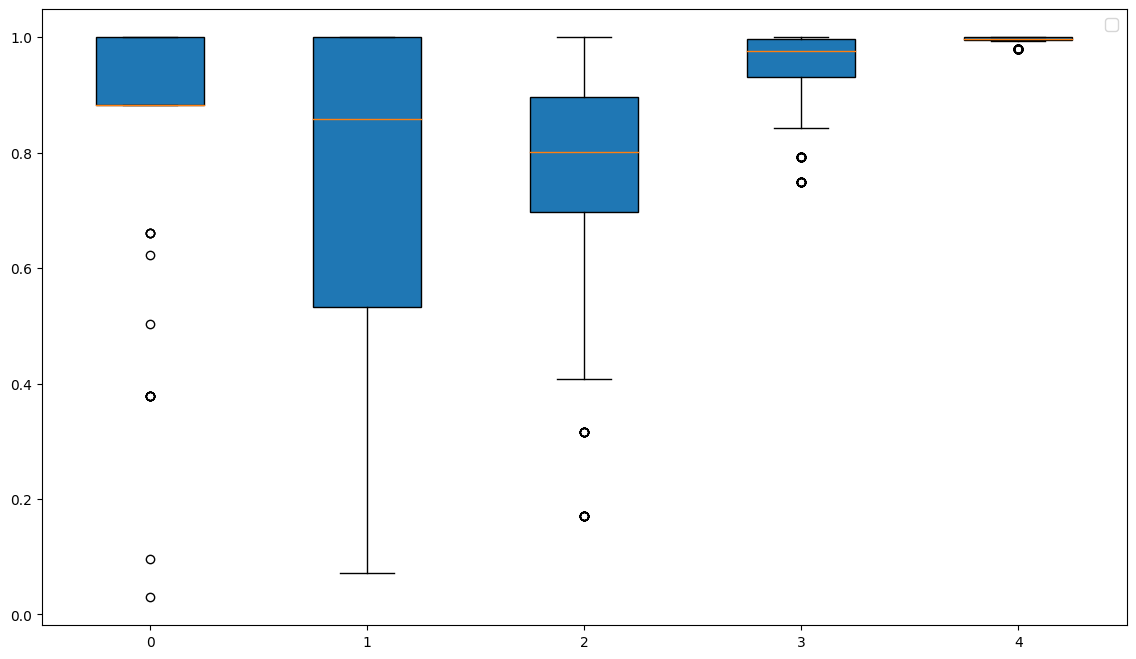

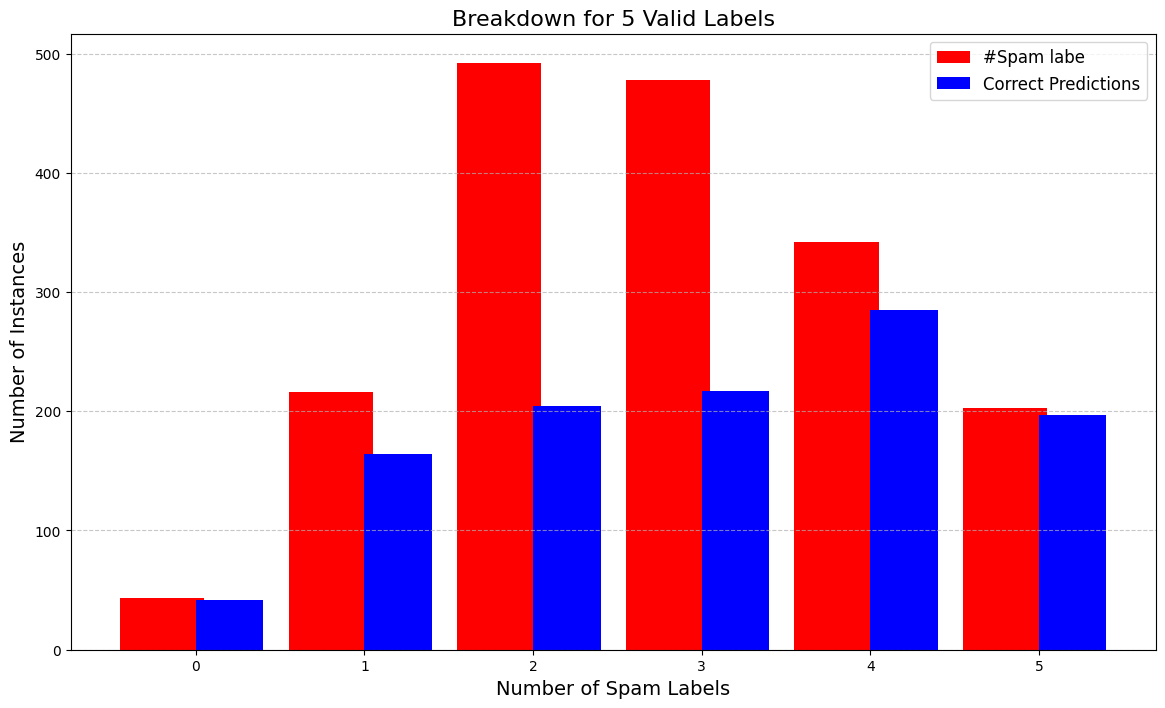

WARNING 2024-08-15 13:37:23,336 [legend.py:_parse_legend_args:1236] No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


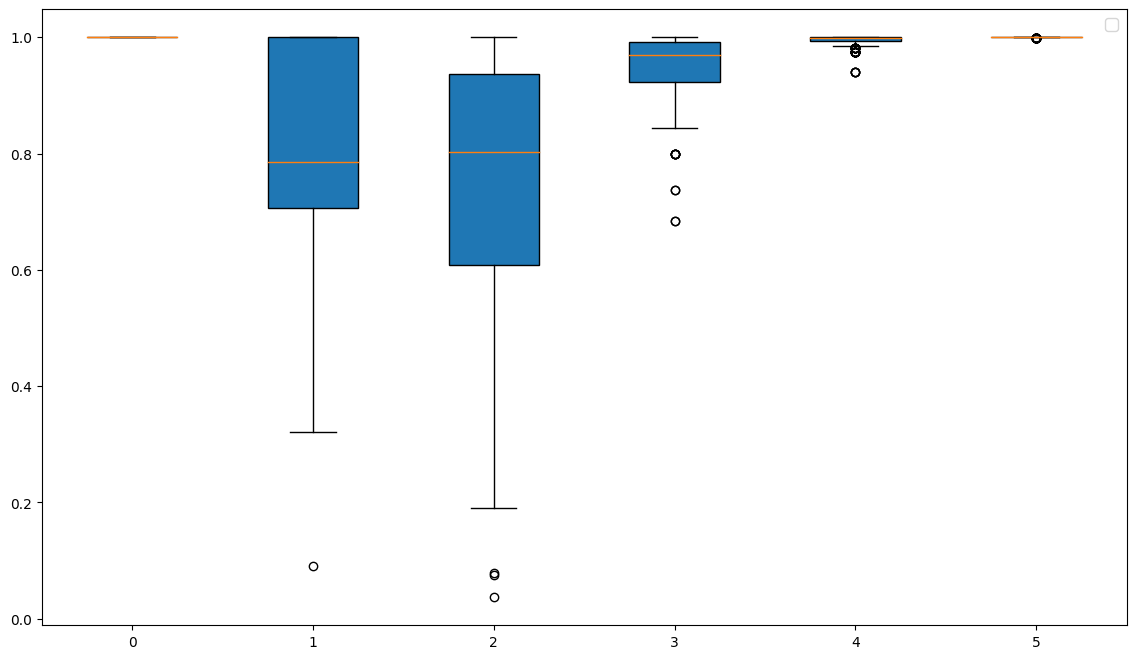

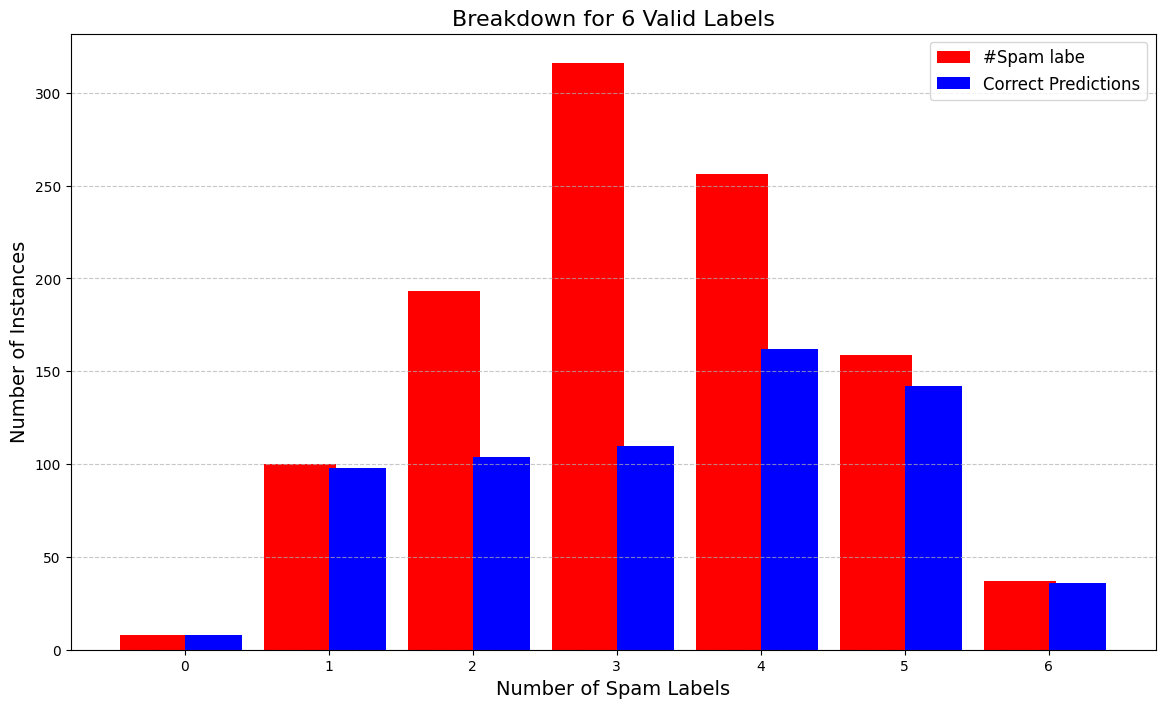

WARNING 2024-08-15 13:37:23,736 [legend.py:_parse_legend_args:1236] No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


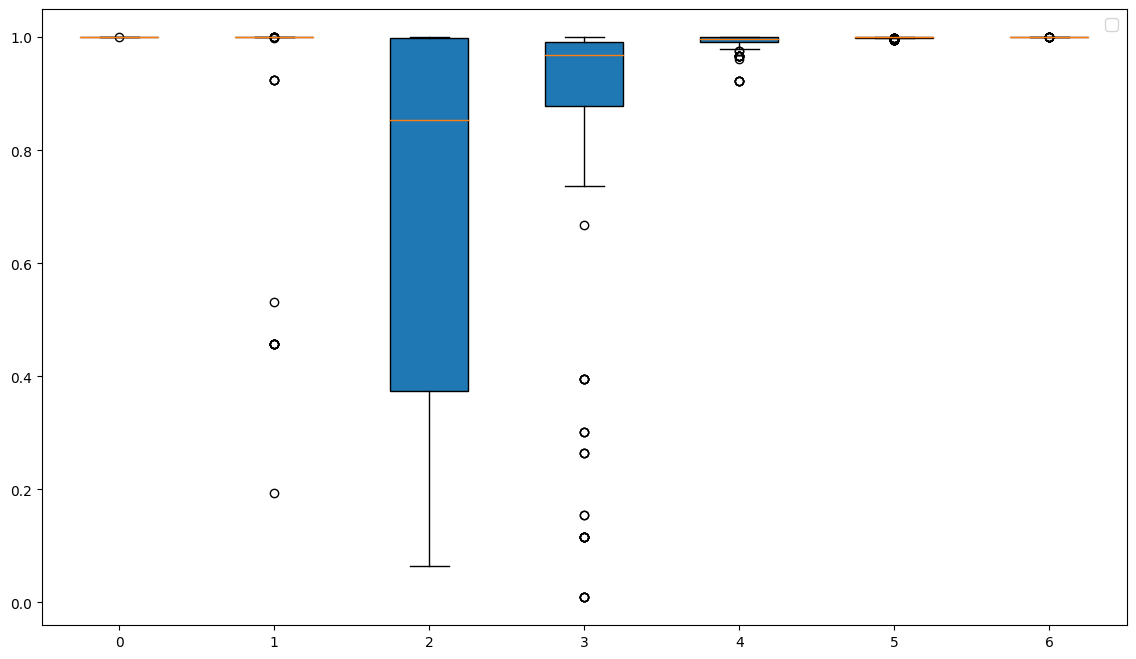

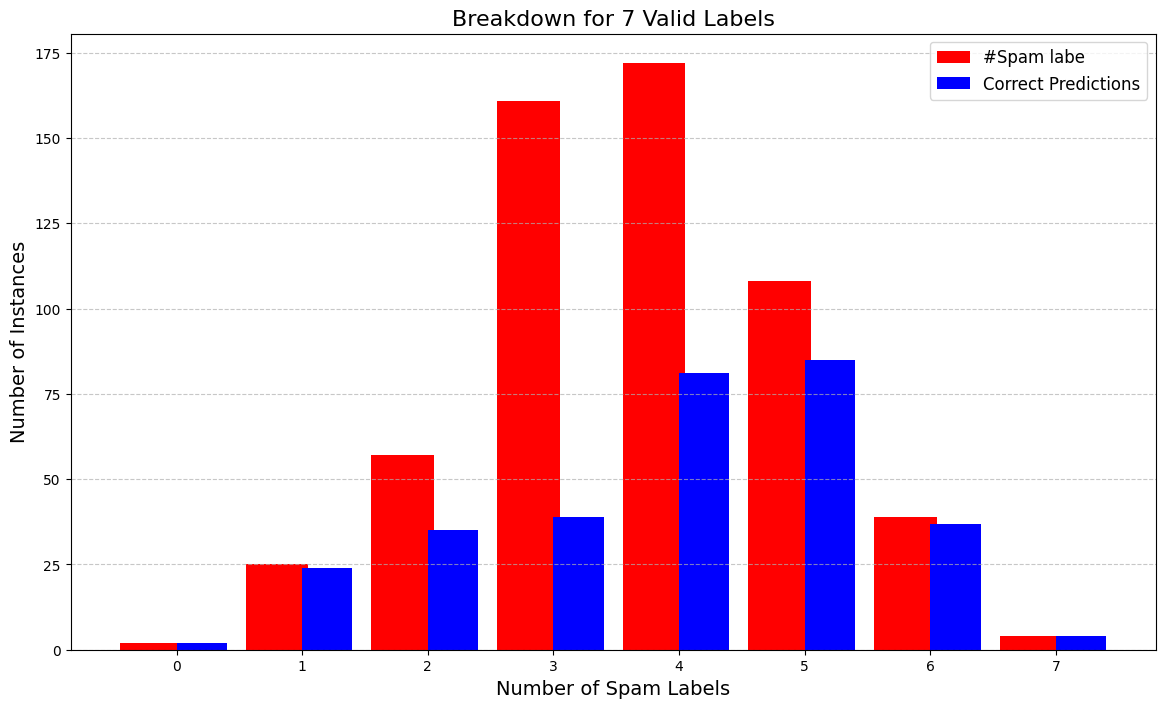

WARNING 2024-08-15 13:37:24,144 [legend.py:_parse_legend_args:1236] No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


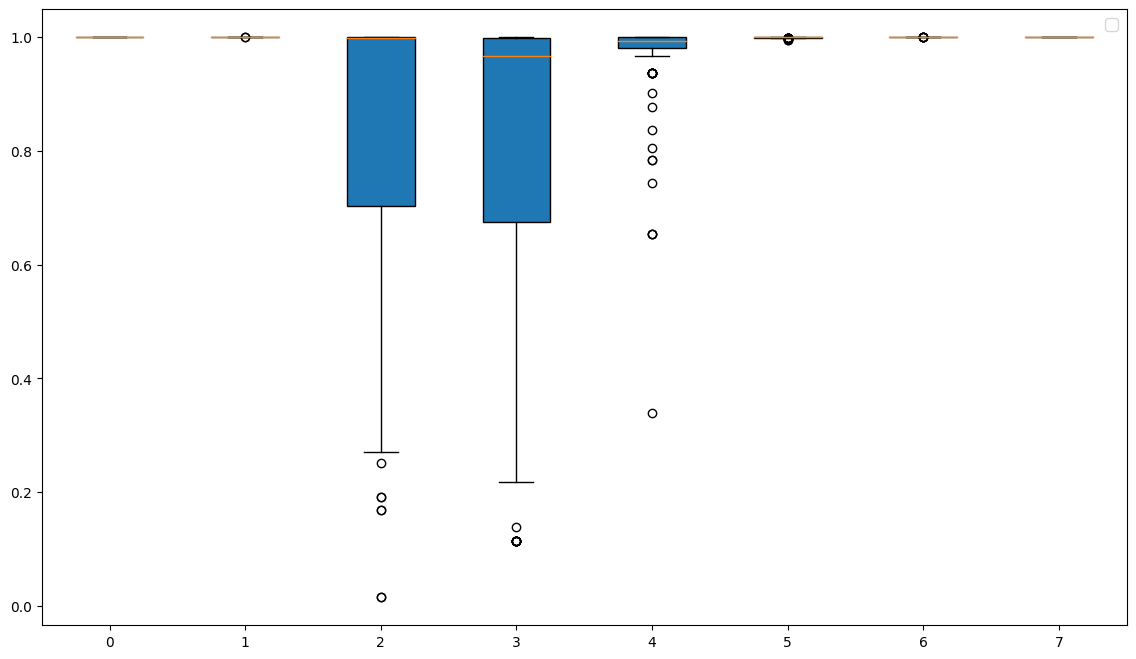

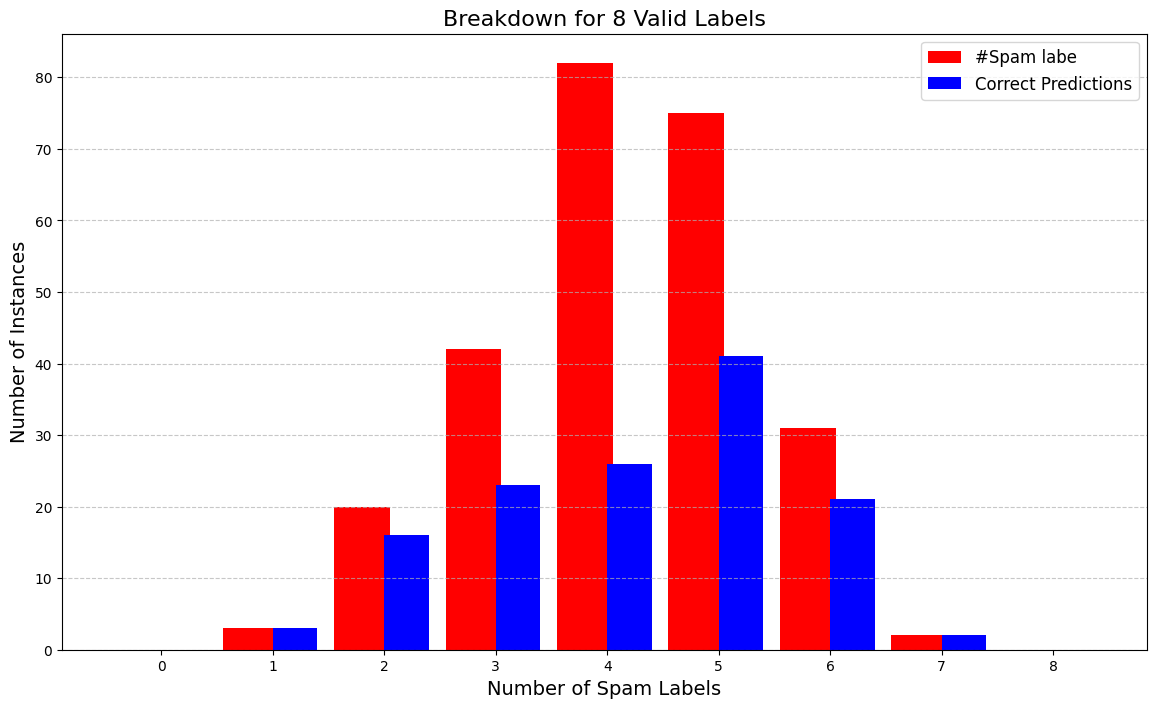

WARNING 2024-08-15 13:37:24,581 [legend.py:_parse_legend_args:1236] No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


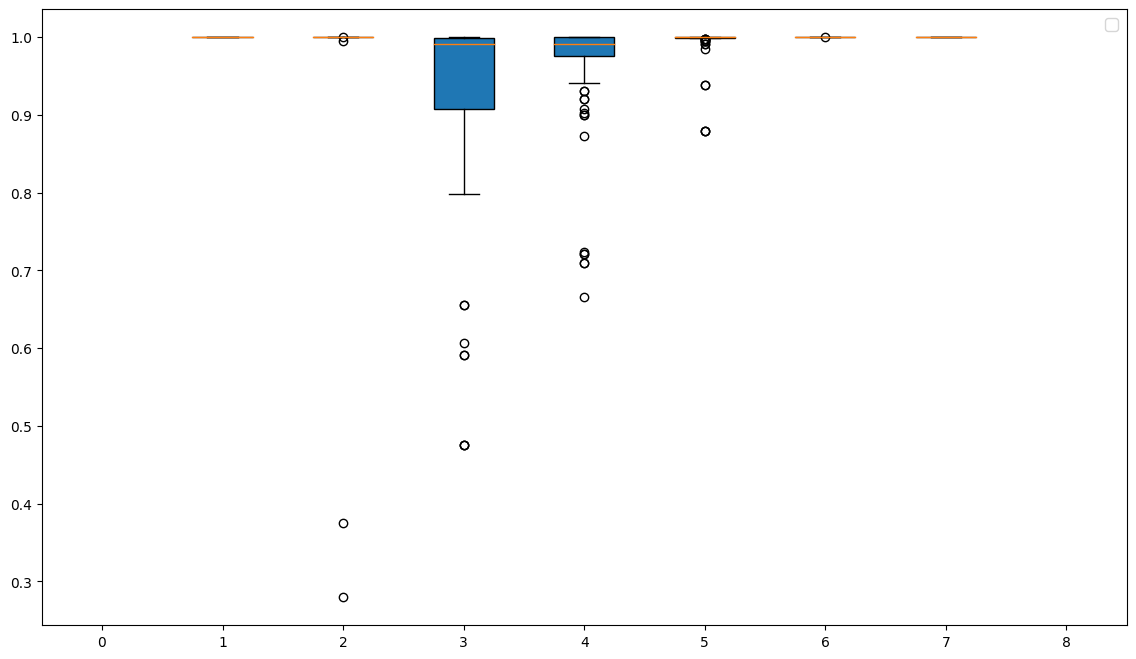

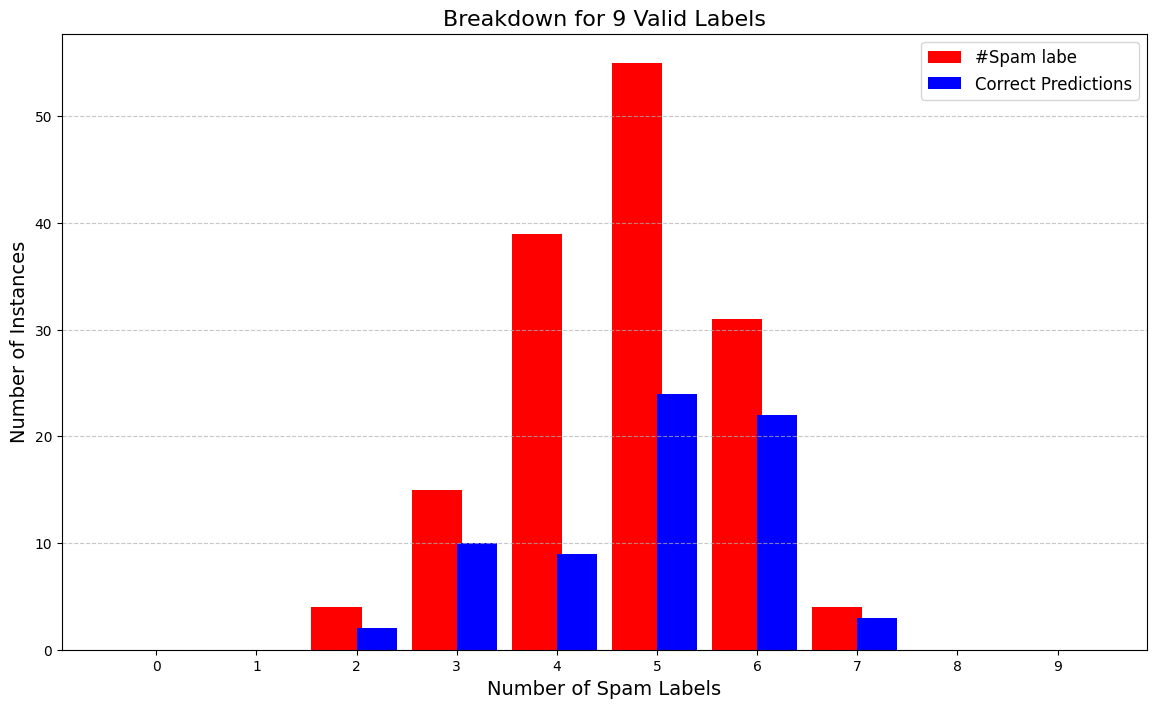

WARNING 2024-08-15 13:37:25,140 [legend.py:_parse_legend_args:1236] No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


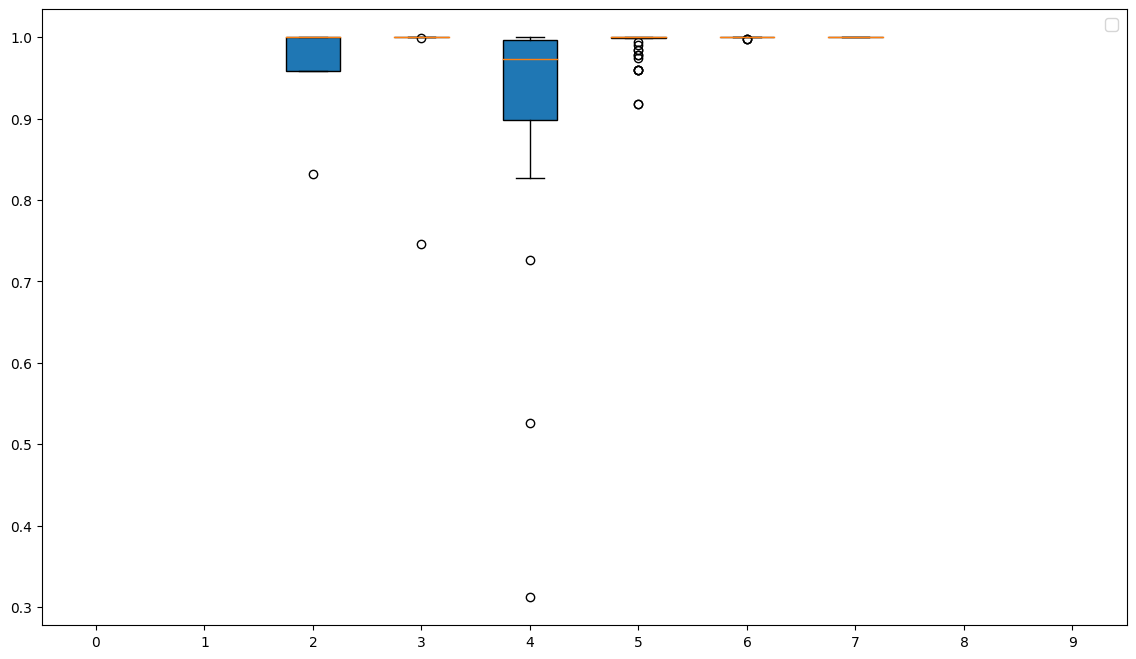

In [184]:
for i in range(1,10):
    drill_down_dist(lf_vectors=lf_vectors, chosen_valid_labels=i, snorkel_probs=snorkel_probs, snorkel_preds=snorkel_predictions)